In [1]:
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import cmocean
import oceans
import csv
import gsw
import glob
%matplotlib inline 

/anaconda/lib/python3.6/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
from cartopy.io.img_tiles import OSM
import cartopy.feature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [3]:
#define interpolation function (standard depth grid given by x_int)
def interpolate(x_int, xvals, yvals):
    yvals_int = []
    for n in range(0, len(yvals)):
        yvals_int.append(np.interp(x_int, xvals[n, :], yvals[n, :]))
    #convert the interpolated data from a list to numpy array
    return np.asarray(yvals_int)

In [4]:
#path lists for files (thanks for telling me about glob because I usually use wget!)
list_of_paths = sorted(glob.glob('Argentine/argo_download/**/**/**/*.nc'))

In [5]:
len(list_of_paths) #this is the total number of data files (i.e. profiles) 

10905

In [26]:
#Open all the files and store the Latitude, Longitude, and Temperature (averaged over the top 20 m) for each profile
#(in principle you could save other fields i.e. temp and sal averaged over isopycnal range)
Lon=[];
Lat=[];
Temp=[];

for i in range(len(list_of_paths)):
    fd=xr.open_mfdataset(list_of_paths[i])
    Lat.append(fd.LATITUDE.values[0])
    Lon.append(fd.LONGITUDE.values[0])
    
    #interpolate temperature onto constant depth grid
    zi = np.arange(0, 1950, 5)
    temp_int=interpolate(zi, fd.PRES.values, fd.TEMP_ADJUSTED.values)
    
    #save temperature averaged over top 20m for each profile 
    Temp.append(np.nanmean(temp_int[:,0:5],axis=1)[0])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


In [27]:
#Convert the stored Lat,Lon,Temp data into an array
Temp=np.asarray(Temp)
Lat=np.asarray(Lat)
Lon=np.asarray(Lon)

#Only take the profiles where Temperature is not nan (otherwise the binned averages don't work)
Lat = Lat[~np.isnan(Temp)]
Lon = Lon[~np.isnan(Temp)]
Temp = Temp[~np.isnan(Temp)]

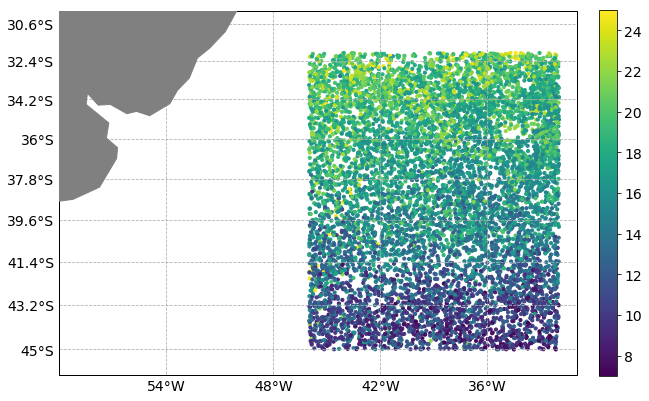

In [29]:
#PLOT A MAP OF PROFILE LOCATION (COLORED BY TEMPERATURE) 
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-60, -31, -30, -46], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--')

cs=ax.scatter(Lon,Lat,c=Temp,s=10,transform=ccrs.PlateCarree())
cb=fig.colorbar(cs, fraction=0.0328, pad=0.04) #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
cs.set_clim(7, 25)
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

In [30]:
#FIND AVERAGES BY 1 DEGREE BOXES
#set lat/lon boundaries for grid and grid spacing
xbins = np.arange(-45,-31,1)
ybins = np.arange(-45,-31,1)
#define a gridded array of all zeros that is the same shape as the lat/lon grid for temperature in each grid box
Tgrid = xr.DataArray(np.zeros_like(ybins)[:,np.newaxis]*xbins, dims=['lat','lon'],
                     coords={'lat':ybins,'lon':xbins})
#define a gridded array of all zeros that is the same shape as the lat/lon grid for number of profiles in each grid box
nDATA = xr.DataArray(np.zeros_like(ybins)[:,np.newaxis]*xbins, dims=['lat','lon'],
                     coords={'lat':ybins,'lon':xbins})

Tgrid=Tgrid.astype(float)

#sort each profile by grid box and store the temperatures and number of profiles in each box
for i in range(len(Temp)):
    ix = np.nanargmin(np.abs(xbins-Lon[i]))
    iy = np.nanargmin(np.abs(ybins-Lat[i]))
    if Lon[i]<xbins[ix]:
        if Lat[i]<ybins[iy]:
            Tgrid[iy-1,ix-1] = Tgrid[iy-1,ix-1]+Temp[i]
            nDATA[iy-1,ix-1] += 1
        else:
            Tgrid[iy,ix-1] = Tgrid[iy,ix-1]+Temp[i]
            nDATA[iy,ix-1] += 1
    else:
        if Lat[i]<ybins[iy]:
            Tgrid[iy-1,ix] = Tgrid[iy-1,ix]+Temp[i]
            nDATA[iy-1,ix] += 1
        else:
            Tgrid[iy,ix] = Tgrid[iy,ix]+Temp[i]
            nDATA[iy,ix] += 1

In [31]:
#CALUCLATE THE MEAN IN EACH GRID BOX
#Tgrid is a sum of all the temperature values from all the profiles in a given grid box so need to divide by the 
#number of profiles in each grid box to get the mean temperature 
Tmean=Tgrid/nDATA

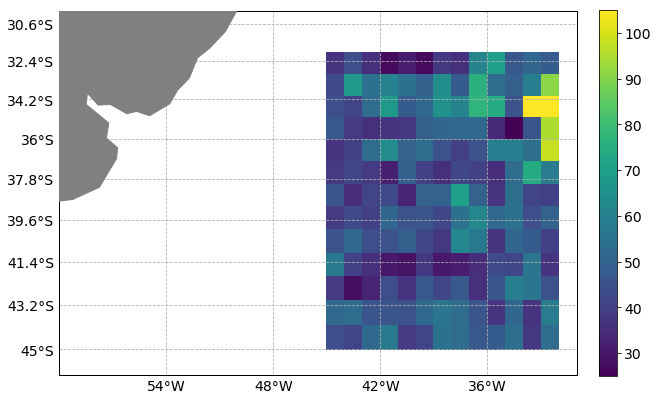

In [32]:
#PLOT THE NUMBER OF PROFILES IN EACH GRID BOX
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-60, -31, -30, -46], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--')

h=ax.pcolor(xbins,ybins,nDATA,transform=ccrs.PlateCarree()) #plot a
#contour map of the chlorophyll data (set values to range from 0 to 1 mg/m3 and use Greens colormap)
cb=fig.colorbar(h, fraction=0.0328, pad=0.04) #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}

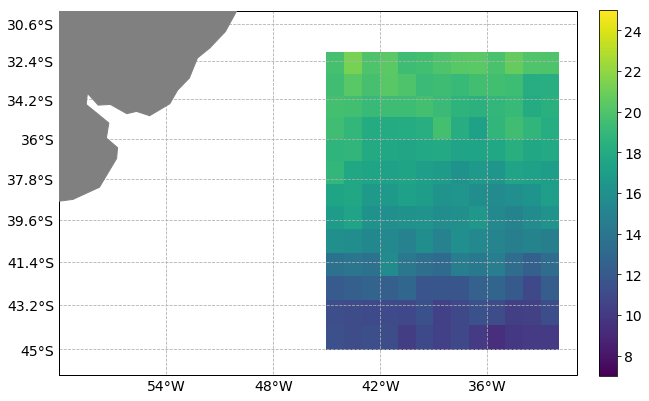

In [33]:
#PLOT THE AVERAGE TEMPERATURE (TOP 20 M) IN EACH GRID BOX
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
ax = plt.axes(projection=ccrs.Mercator()) #chose mapping projection for plot
ax.set_extent([-60, -31, -30, -46], crs=ccrs.PlateCarree()) #set axes limits for plot (this example shows Maud Rise) 
g = ax.gridlines(draw_labels=True,linestyle='--')

h=ax.pcolor(xbins,ybins,Tmean,vmin=7,vmax=25,transform=ccrs.PlateCarree()) #plot a
#contour map of the chlorophyll data (set values to range from 0 to 1 mg/m3 and use Greens colormap)
cb=fig.colorbar(h, fraction=0.0328, pad=0.04)#,extend='both') #add colorbar to figure
cb.ax.tick_params(labelsize=14) #set fontsize of colorbar labels
ax.add_feature(cartopy.feature.LAND,color='gray',zorder=3) #add coastlines to the map
#the rest is all cosmetic stuff about the plot (fontsize of lat/lon labels etc)
g.xlabels_top = False
g.ylabels_right = False
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
g.xformatter = LONGITUDE_FORMATTER
g.yformatter = LATITUDE_FORMATTER
g.xlabel_style = {'size': 14}
g.ylabel_style = {'size': 14}